## Name : Adwaiy Singh
## Reg. No. : 220968424
## Sec. : A
## Batch: 2

# WEEK 7

In [1]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import bigrams
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<br\s*/?>', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(cleaned_tokens)

In [4]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [6]:
train_df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,I grew up (b. 1965) watching and loving the Th...,grew b 1965 watching loving thunderbird mate s...
1,"When I put this movie in my DVD player, and sa...",put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,im die hard dad army fan nothing ever change g...


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


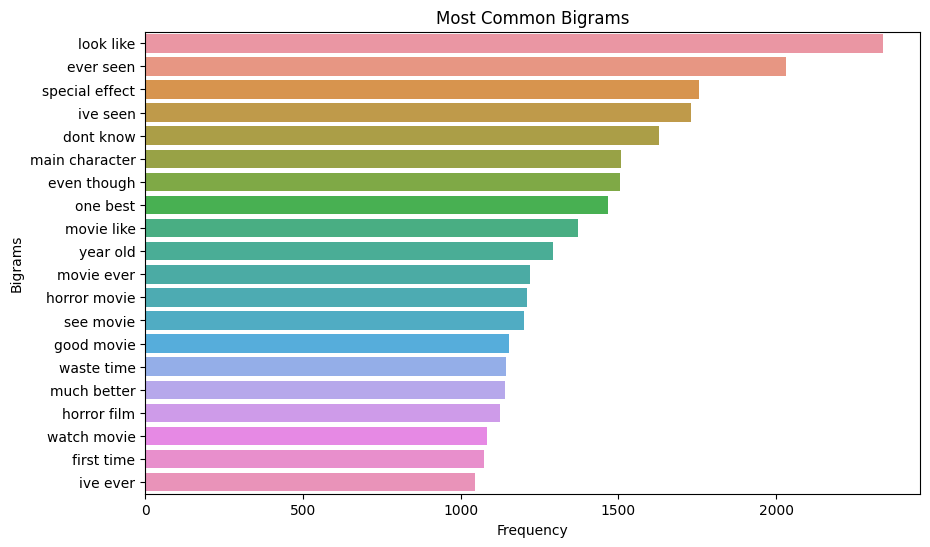

In [7]:
bigrams_list = list(itertools.chain(*[list(bigrams(text.split())) for text in train_df['cleaned_text']]))

bigram_freq = Counter(bigrams_list)
common_bigrams = bigram_freq.most_common(20) 
bigram_words, bigram_counts = zip(*common_bigrams)
bigram_words = [' '.join(pair) for pair in bigram_words] 

plt.figure(figsize=(10, 6))
sns.barplot(x=list(bigram_counts), y=list(bigram_words))
plt.title('Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

In [8]:
positive_reviews = train_df[train_df['label'] == 1]['cleaned_text']
negative_reviews = train_df[train_df['label'] == 0]['cleaned_text']

In [9]:
positive_words = ' '.join(positive_reviews).split()
positive_word_freq = Counter(positive_words).most_common(20)

negative_words = ' '.join(negative_reviews).split()
negative_word_freq = Counter(negative_words).most_common(20)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


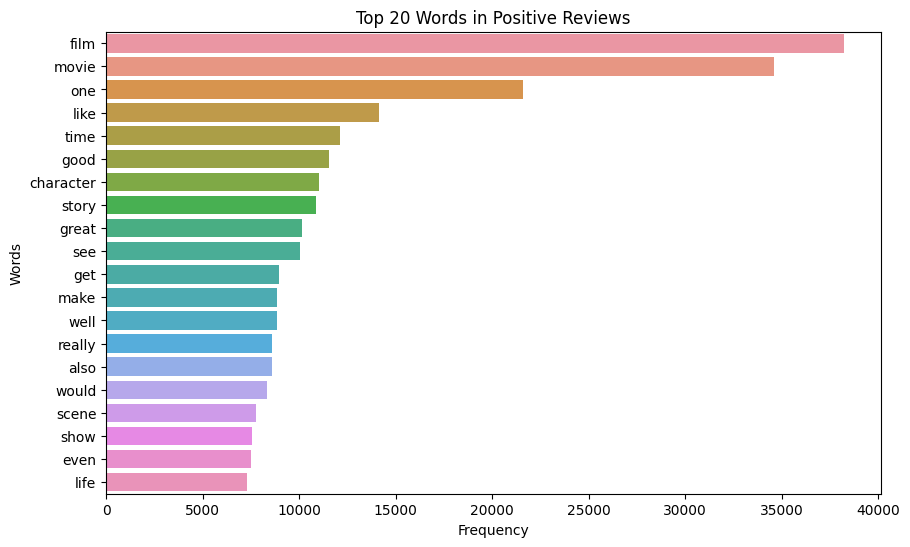

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


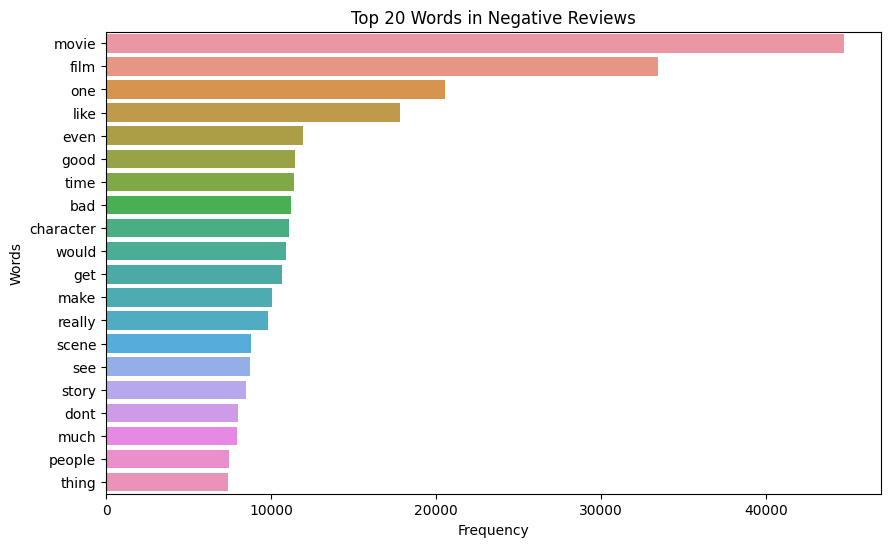

In [10]:
pos_words, pos_counts = zip(*positive_word_freq)
neg_words, neg_counts = zip(*negative_word_freq)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(pos_counts), y=list(pos_words))
plt.title('Top 20 Words in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(neg_counts), y=list(neg_words))
plt.title('Top 20 Words in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [11]:
vocab_size = 10000 
max_length = 200 

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
val_sequences = tokenizer.texts_to_sequences(val_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [12]:
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

In [13]:
embedding_dim = 100

def build_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gru_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_bi_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [14]:
def train_and_evaluate_model(model, train_data, train_labels, val_data, val_labels, epochs=10, batch_size=32):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.show()
    
    test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
    return test_accuracy

### LSTM Model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.5024 - loss: 0.6937 - val_accuracy: 0.5100 - val_loss: 0.6948
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5578 - loss: 0.6763 - val_accuracy: 0.5952 - val_loss: 0.6710
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.6113 - loss: 0.6560 - val_accuracy: 0.8136 - val_loss: 0.4424
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8428 - loss: 0.3896 - val_accuracy: 0.8624 - val_loss: 0.3523
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8874 - loss: 0.2914 - val_accuracy: 0.8778 - val_loss: 0.3012
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9027 - loss: 0.2545 - val_accuracy: 0.8760 - val_loss: 0.3487
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9234 - loss: 0.2164 - val_accuracy: 0.8880 - val_loss: 0.2933
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9408 -

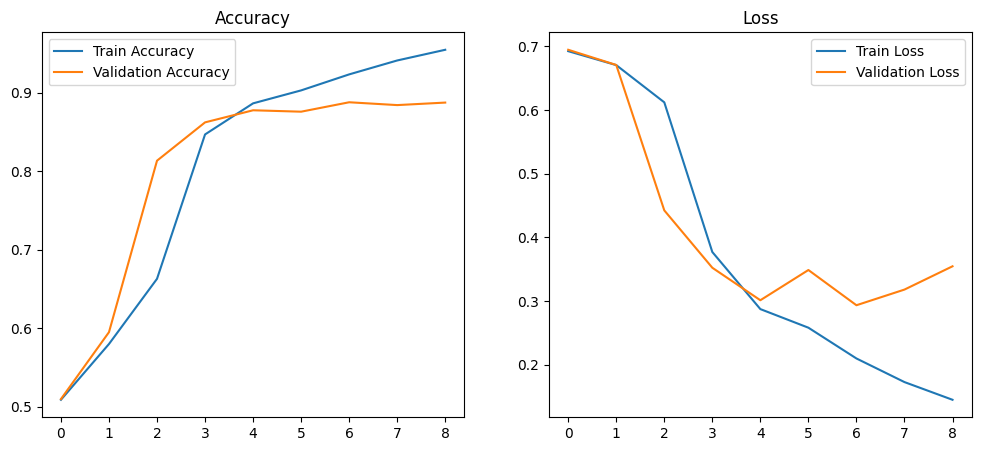

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8839 - loss: 0.2903
LSTM Test Accuracy: 0.8884


In [15]:
lstm_model = build_lstm_model()
lstm_accuracy = train_and_evaluate_model(lstm_model, train_padded, train_labels, val_padded, val_labels)
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")

### GRU Model

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.5125 - loss: 0.6886 - val_accuracy: 0.8548 - val_loss: 0.3484
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8806 - loss: 0.2867 - val_accuracy: 0.8908 - val_loss: 0.2663
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.9438 - loss: 0.1570 - val_accuracy: 0.8994 - val_loss: 0.2721
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.9694 - loss: 0.0932 - val_accuracy: 0.8848 - val_loss: 0.3174


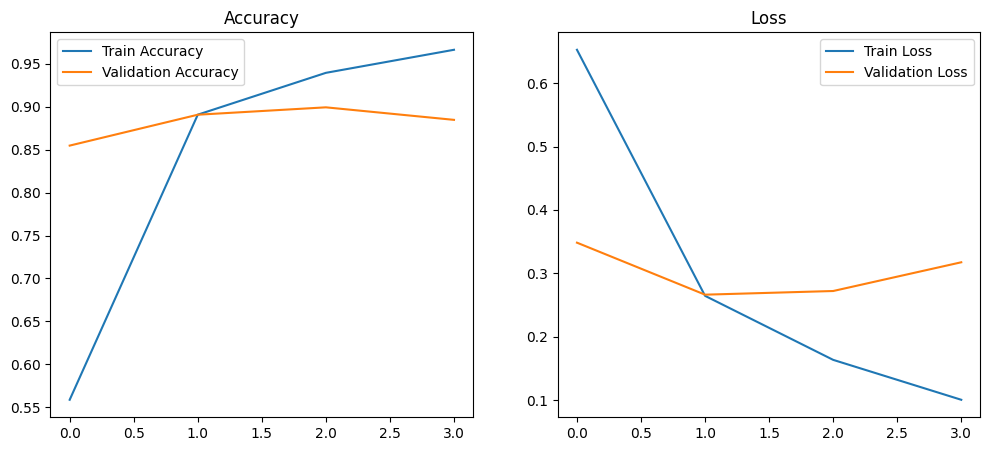

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8867 - loss: 0.2788
GRU Test Accuracy: 0.8882


In [16]:
gru_model = build_gru_model()
gru_accuracy = train_and_evaluate_model(gru_model, train_padded, train_labels, val_padded, val_labels)
print(f"GRU Test Accuracy: {gru_accuracy:.4f}")

### BiDirectional LSTM Model

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 98ms/step - accuracy: 0.7135 - loss: 0.5592 - val_accuracy: 0.8488 - val_loss: 0.3589
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.8754 - loss: 0.3111 - val_accuracy: 0.8732 - val_loss: 0.3029
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.9053 - loss: 0.2489 - val_accuracy: 0.8668 - val_loss: 0.3194
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 98ms/step - accuracy: 0.9085 - loss: 0.2387 - val_accuracy: 0.8778 - val_loss: 0.2993
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 98ms/step - accuracy: 0.9329 - loss: 0.1889 - val_accuracy: 0.8884 - val_loss: 0.2892
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.9490 - loss: 0.1481 - val_accuracy: 0.8802 - val_loss: 0.3184
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.9635 - loss: 0.1171 - val_accuracy: 0.8798 - val_loss: 0.3718


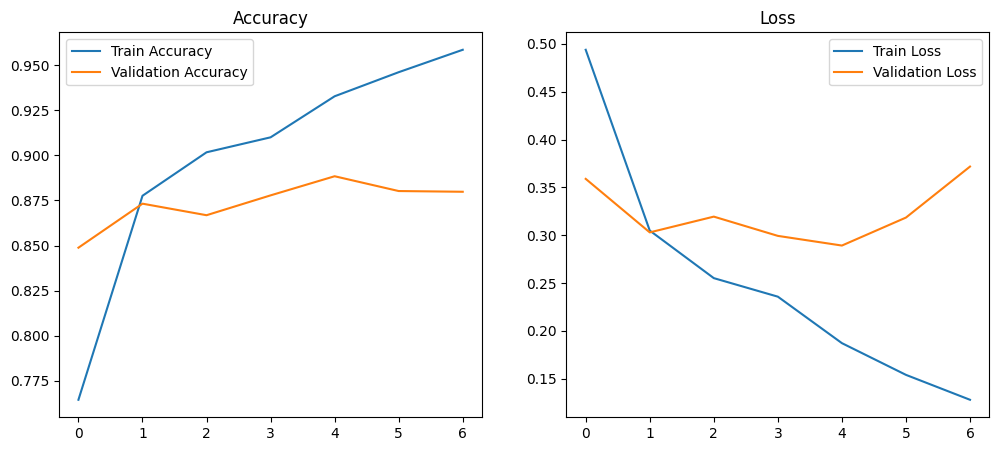

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8871 - loss: 0.2860
Bidirectional RNN Test Accuracy: 0.8862


In [17]:
bi_rnn_model = build_bi_rnn_model()
bi_rnn_accuracy = train_and_evaluate_model(bi_rnn_model, train_padded, train_labels, val_padded, val_labels)
print(f"Bidirectional RNN Test Accuracy: {bi_rnn_accuracy:.4f}")

### LSTM seemed to have the best performance, although all three models perform very similarly on the test data.
### GRU was the fastest and BiDirectional LSTM was the slowest